In [57]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt


<Figure size 1500x1000 with 0 Axes>

In [87]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)


full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [97]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv

clusterframes = {}

grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df_cluster = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    groupname = group[0]
    df = group[1].iloc[:,:-33]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    group1_mean_list = []
    group2_mean_list = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2)
        pvaluelist.append(test[1])
        group_mean = group.mean()
        group1_mean_list.append(group_mean)
        group2_mean = group2.mean()
        group2_mean_list.append(group2_mean) 
        
    
    df_cluster[f'Cluster {groupname}'] = group1_mean_list
    df_cluster['Other clusters'] = group2_mean_list
    df_cluster['Fold Change'] = np.log2(abs(df_cluster[f'Cluster {groupname}'])) - np.log2(abs(df_cluster['Other clusters']))
    
    
    df_cluster['p-values'] = pvaluelist
    qv.qvalues(df_cluster, 'p-values', f'cluster {groupname} qvalues')
    #df_cluster['p-values'] = -np.log10(df_cluster['p-values'])
    #df_cluster[f'cluster {groupname} qvalues'] = -np.log10(df_cluster[f'cluster {groupname} qvalues'])
    print(groupname)
    clusterframes[groupname] = df_cluster
        
        

1
10
2
3
4ER+
4ER-
5
6
7
8
9


In [99]:
clusterframes

{'1':                                                     Cluster 1  Other clusters  \
 Chromosome Maintenance                               4.327115       -0.324592   
 RMTs methylate histone arginines                     4.292748       -0.322014   
 Cellular Senescence                                  4.878702       -0.365968   
 Nucleosome assembly                                  4.022459       -0.301739   
 Deposition of new CENPA-containing nucleosomes ...   4.022459       -0.301739   
 ...                                                       ...             ...   
 CTLA4 inhibitory signaling                          -0.107032        0.008029   
 Clathrin-mediated endocytosis                       -0.184275        0.013823   
 Regulation of PTEN localization                     -0.041877        0.003141   
 Adaptive Immune System                              -0.344693        0.025856   
 Norepinephrine Neurotransmitter Release Cycle       -0.095863        0.007191   
 
         

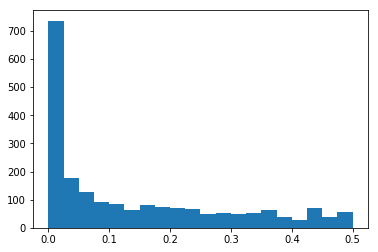

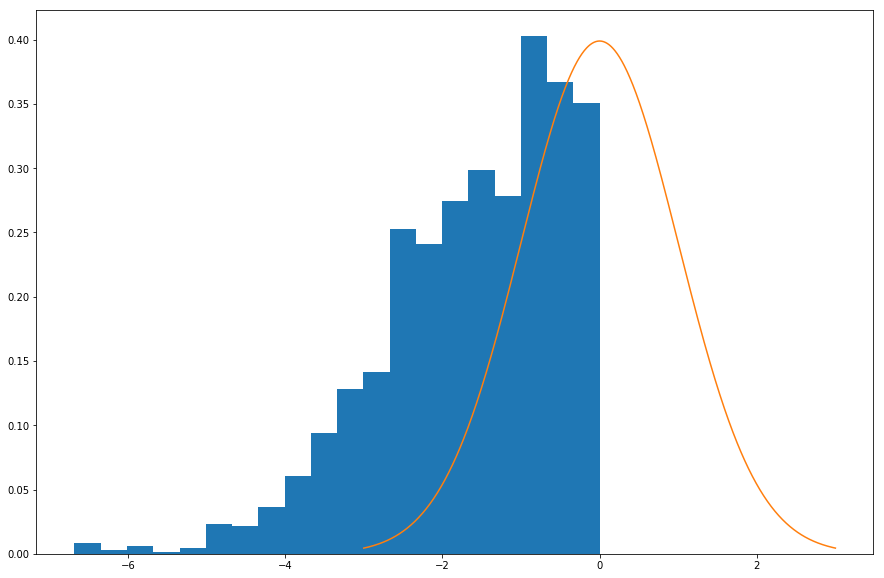

In [126]:
from scipy.stats import norm
def null_testing_cluster(cluster):
    ##Generate Zscores
    #series = zscore(clusterframes[cluster][f'cluster {cluster} qvalues'])
    plt.hist(clusterframes[cluster][f'p-values'], bins=20)
    plt.show()
    p_significance = norm.ppf(clusterframes[cluster][f'p-values'])
    
    ## Plot distribution of pathway eigenvalues
    plt.figure(figsize=(15, 10))
    plt.hist(p_significance, bins=20, density=True)

    ##Null distribution
    x = np.linspace(mu -3*sigma, mu+ 3*sigma, 1000)
    plt.plot(x, norm.pdf(x, 0, 1))
    plt.savefig(f'cluster_{cluster}_p_distribution.png')
    plt.show()
    
null_testing_cluster('2')


In [118]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
results = ols("Q('Interleukin-7 signaling') ~ C(Q('Integrative Cluster'))", data=full_df).fit()
table = sm.stats.anova_lm(results, typ=2)
print(table)

                                  sum_sq      df          F        PR(>F)
C(Q('Integrative Cluster'))  1440.973130    10.0  33.259333  3.272314e-60
Residual                     8530.766768  1969.0        NaN           NaN
